In [2]:
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.kernel_regression import KernelReg

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
os.getcwd()

'/Users/lilimatic/var_imp_mis/nonparametric regression'

In [5]:
os.chdir('/Users/lilimatic/var_imp_mis')
from function import *

In [6]:
df = pd.read_csv('data_sim.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
n = len(df[:100])
df=df[:100]

eps = np.random.normal(0, 0.1, len(df))

a = 2
b = 2

b0=0.5
b1 = 0.5

sim = 100

p = 0.7

In [5]:
settings=nparam.EstimatorSettings(efficient=True)

In [6]:
#y = dataset(n,df).ishigami(eps)(a,b)

#model_pf = KernelReg(endog=[y.to_numpy()],exog=[df['X1'],df['X2'],df['X3']],reg_type='lc',var_type='ccc', bw='cv_ls',defaults=settings)
#y_hat_true = model_pf.fit([df['X1'],df['X2'],df['X3']])[0]

In [7]:
def sobol_reg(df,n1,request,sim,a,b,eps):
    sobol_list = []
    df1 = df.copy()
    for x in range(sim):
        #Compute y_hat
        y = dataset(n1,df1).ishigami(eps)(a,b)
        model_pf = KernelReg(endog=[y.to_numpy()],exog=[df1['X1'],df1['X2'],df1['X3']],reg_type='lc',var_type='ccc', bw='cv_ls',defaults=settings)
        y_hat = model_pf.fit([df1['X1'],df1['X2'],df1['X3']])[0]
        #Pick-Freezed
        df_pf   = dataset(n1,df).picked(request,a,b)
        df_pf['Y'] = dataset(n1,df_pf).ishigami(eps)(a,b)
        model_pf = KernelReg(endog=[df_pf['Y'].to_numpy()],exog=[df_pf['X1'],df_pf['X2'],df_pf['X3']],reg_type='lc',var_type='ccc', bw='cv_ls',defaults=settings)
        df_pf['Y_hat'] = model_pf.fit([df_pf['X1'],df_pf['X2'],df_pf['X3']])[0]
        sobol_list.append((np.cov(y_hat,df_pf['Y_hat'],bias=True)/np.var(y_hat))[0][1])
    return sobol_list

In [8]:
#sobol_reg(df,n,['X2','X3'],10,a,b,eps,y_hat)

In [9]:
def singletons_reg(df,n1,sim,a,b,eps):
    singleton = []
    for x in [['X2','X3'],['X1','X3'],['X1','X2']]:
        singleton.append(sobol_reg(df,n1,x,sim,a,b,eps))
    return pd.DataFrame(dict(zip(['X1','X2','X3'],singleton)))




In [10]:
def singleton_reg(df,Xi,n,p,sample):
    omega = pd.DataFrame(np.random.binomial(size=n, n=1, p= p),columns=[Xi])
    omega[df.drop([Xi],axis=1).columns]=  np.ones((n,2),dtype=int)
    cc = df.where(omega==1,np.nan).dropna()
    print(len(cc))
    single_sobol_cc = singletons_reg(df,n,sim,a,b,eps)
    #fig, ax = plt.subplots()
    #ax.boxplot(single_sobol_cc)
    #ax.set_xticklabels(single_sobol_cc.columns)
    single_sobol_cc['sample'] = sample
    return single_sobol_cc

In [11]:
#singleton_reg(df,'X1',n,p,'cc')

X1 is missing

0.9
100


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmode

93


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmode

X1 is missing

0.7
100


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/si

69


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/hom

X1 is missing

0.4
100


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/si

37


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/si

X2 is missing

0.9
100


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/si

93


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmode

X2 is missing

0.7
100


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/hom

78


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/si

X2 is missing

0.4
100


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/hom

43


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/si

X3 is missing

0.9
100


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmode

85


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmode

X3 is missing

0.7
100


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmode

77


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/hom

X3 is missing

0.4
100


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/si

34


/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
/home/jlm217/.local/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/home/jlm217/.local/lib/python3.11/si

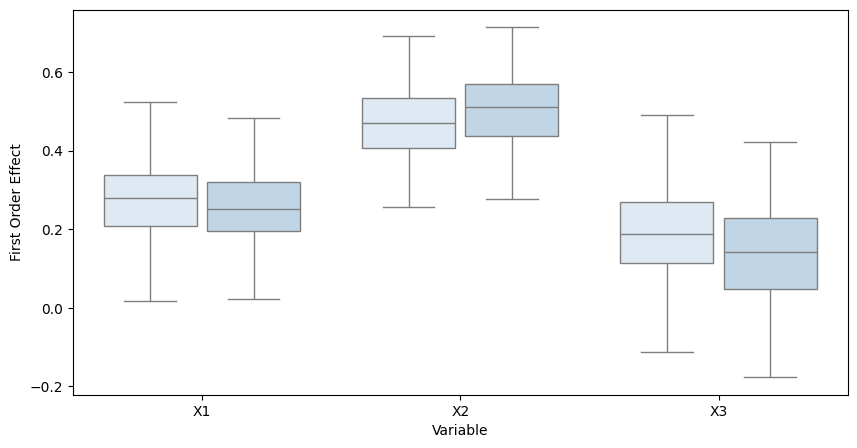

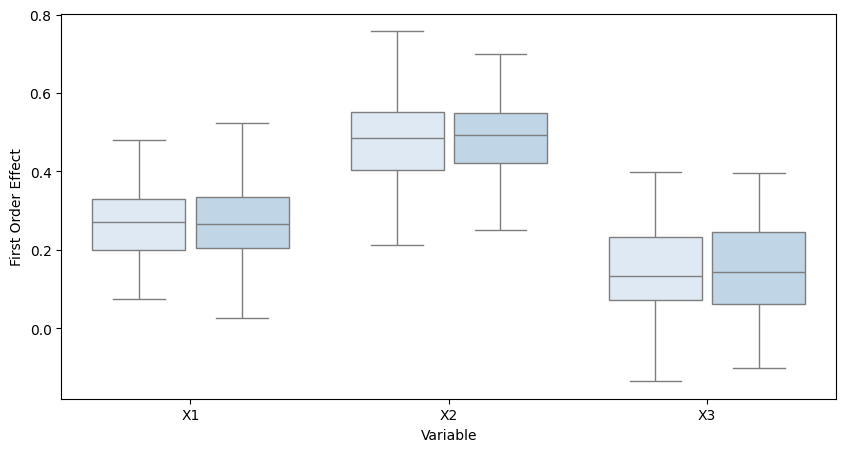

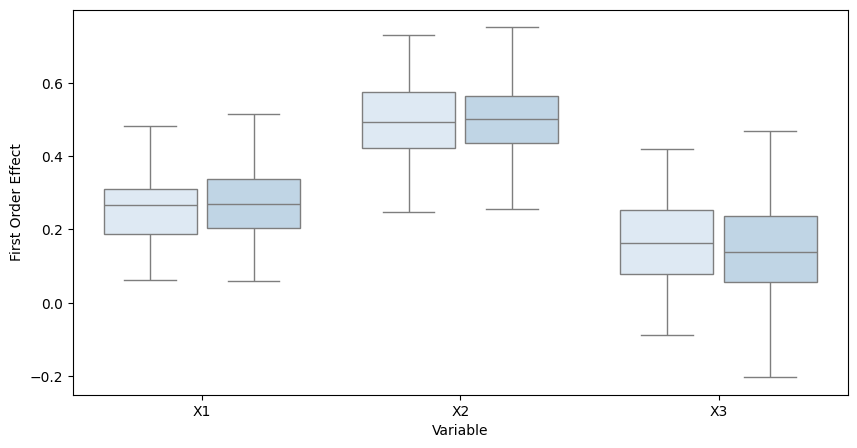

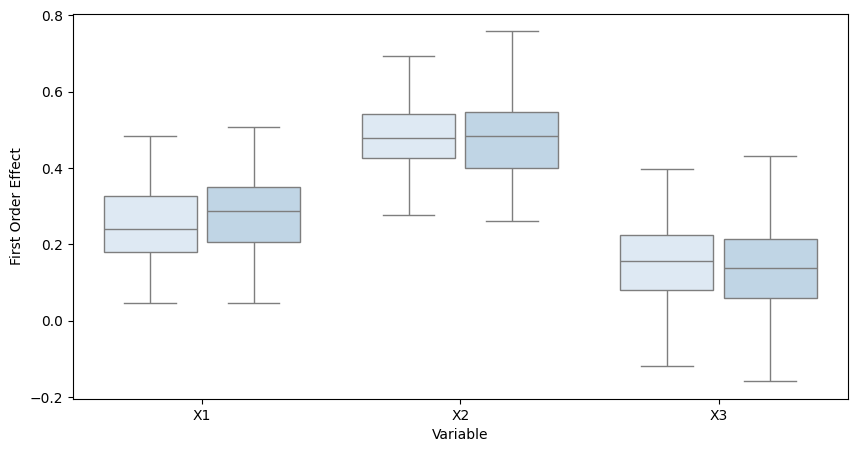

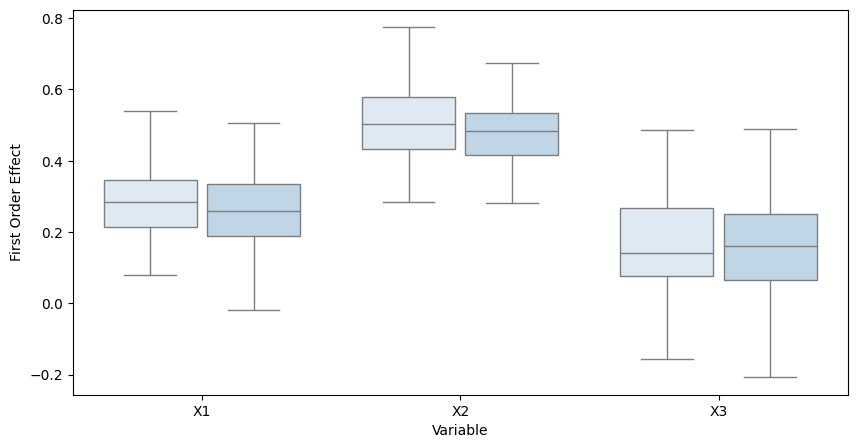

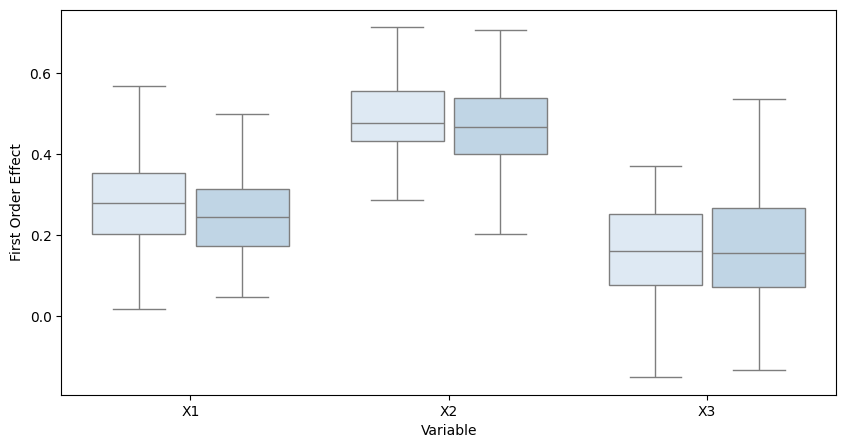

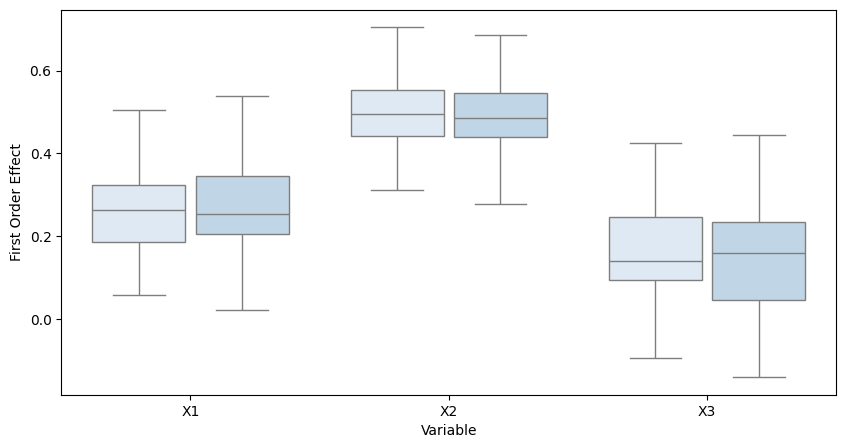

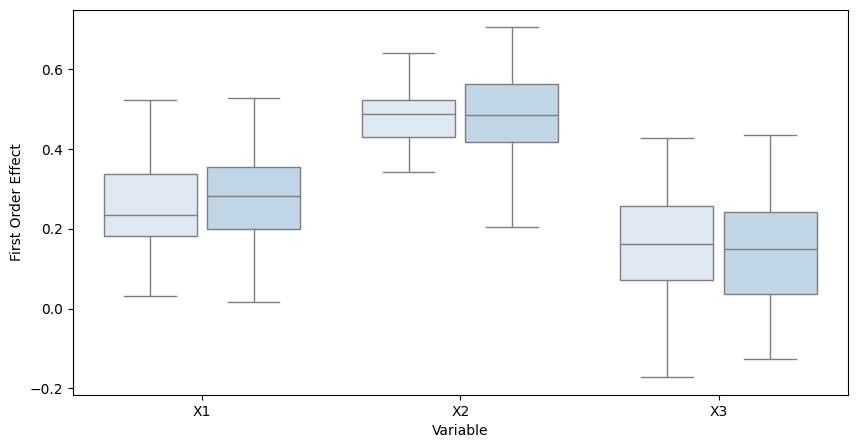

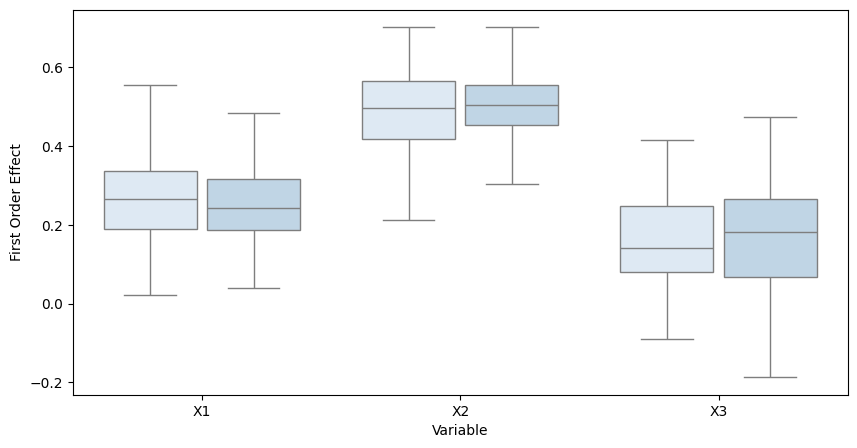

In [12]:
for x in ['X1','X2','X3']: #0.4,0.7,
    for p in [0.9,0.7,0.4]: #0.4,0.7,
        print(x+ ' is missing')
        print()
        print(p)
        single_sobol = singleton_reg(df,x,n,1,'complete')
        single_sobol_cc = singleton_reg(df,x,n,p,'cc')

        cdf = pd.concat([single_sobol, single_sobol_cc],axis=0)  
    
        dd = pd.melt(cdf, id_vars= ['sample'],value_vars=['X1','X2','X3'],var_name='Variable')
        dd = dd.rename(columns={'value':'First Order Effect'})
        
        dd.to_csv(f'nonparametric regression/mcar_run/{x}_mcar_{p}.csv')
 
        fig, ax = plt.subplots(1, 1,figsize=(10, 5))
    
        ax = sns.boxplot(x='Variable',y='First Order Effect',data=dd,hue='sample',palette=sns.color_palette('Blues'),showfliers = False) #"Blues" "cubehelix" flare_r'
        ax.legend_.remove()
        #ax.set(ylim=(0, 0.6))
        fig = ax.get_figure()
        adjust_box_widths(fig, 0.9)
        fig.savefig('nonparametric regression/mcar/MCAR_'+str(x)+'_'+str(p)+'.pdf',transparent=True,bbox_inches='tight')


300
300


<ipython-input-10-59289b9abcb9>:19: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.boxplot(x='Variable',y='First Order Effect',data=dp,hue='prob',palette=sns.color_palette('Blues'),showfliers = False,hue_order=[1,0.9,0.7,0.4]) #"Blues" "cubehelix" flare_r'


300
300


<ipython-input-10-59289b9abcb9>:19: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.boxplot(x='Variable',y='First Order Effect',data=dp,hue='prob',palette=sns.color_palette('Blues'),showfliers = False,hue_order=[1,0.9,0.7,0.4]) #"Blues" "cubehelix" flare_r'
<ipython-input-10-59289b9abcb9>:19: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.boxplot(x='Variable',y='First Order Effect',data=dp,hue='prob',palette=sns.color_palette('Blues'),showfliers = False,hue_order=[1,0.9,0.7,0.4]) #"Blues" "cubehelix" flare_r'


300
300


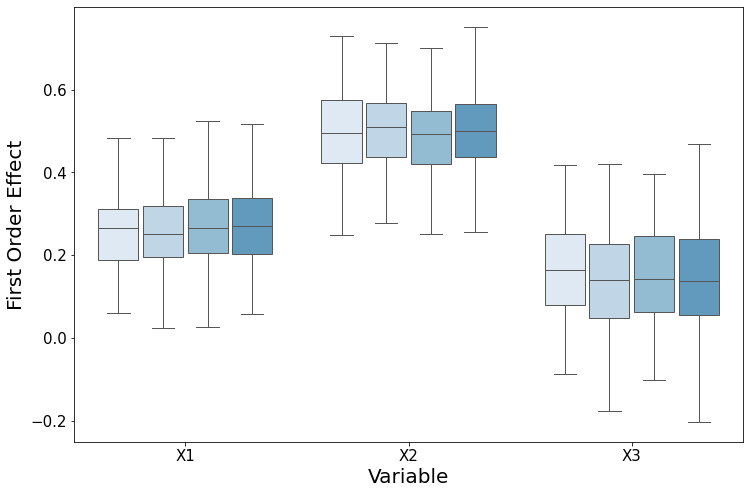

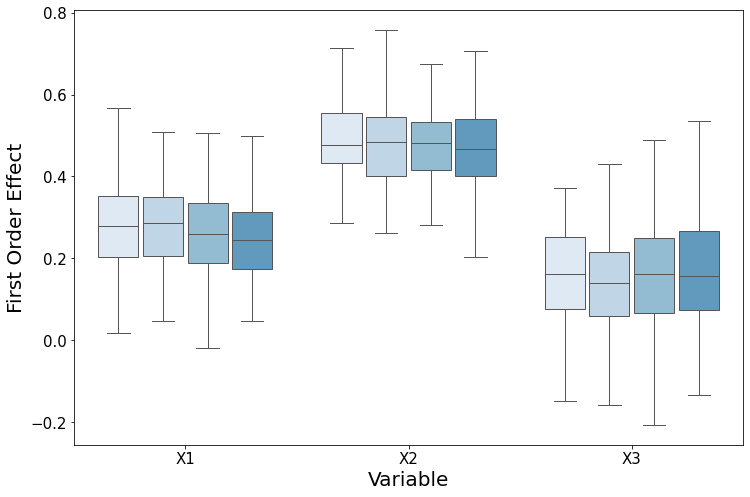

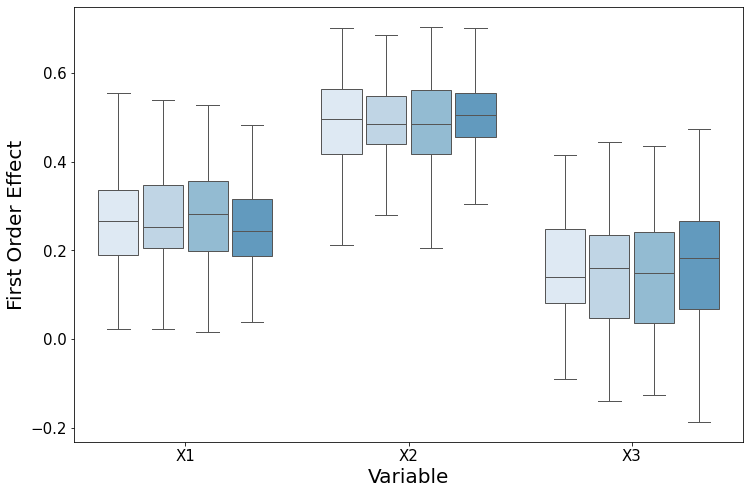

In [10]:
for x in ['X1','X2','X3']:
    dX14 = pd.read_csv(f'nonparametric regression/mcar_run/{x}_mcar_0.4.csv')
    dX14['prob'] =  dX14['sample'].apply(lambda x: 1 if x =='complete' else 0.4)

    dX16 = pd.read_csv(f'nonparametric regression/mcar_run/{x}_mcar_0.7.csv')
    dX16 = dX16.loc[(dX16['sample']=='cc')]
    dX16['prob'] = 0.7
    print(len(dX16))

    dX19 = pd.read_csv(f'nonparametric regression/mcar_run/{x}_mcar_0.9.csv')
    dX19 = dX19.loc[(dX19['sample']=='cc')]
    dX19['prob'] = 0.9
    print(len(dX19))

    dp = pd.concat([dX14,dX16,dX19],axis=0,ignore_index=False)
    
    fig, ax = plt.subplots(1, 1,figsize=(12, 8))
    
    ax = sns.boxplot(x='Variable',y='First Order Effect',data=dp,hue='prob',palette=sns.color_palette('Blues'),showfliers = False,hue_order=[1,0.9,0.7,0.4]) #"Blues" "cubehelix" flare_r'
    ax.legend_.remove()
    #ax.set(ylim=(0.05, 0.58))
    fig = ax.get_figure()
    adjust_box_widths(fig, 0.9)
    plt.xticks(fontsize = 15) 
    plt.yticks(fontsize = 15) 
    ax.set_xlabel('Variable', fontsize = 20) 
    ax.set_ylabel('First Order Effect', fontsize = 20) 
    fig.savefig(f'nonparametric regression/{x}_MCAR_p_np.pdf',transparent=True,bbox_inches='tight')